In [1]:
import numpy as np
import os
import tqdm
import matplotlib.pyplot as plt
import math
import cv2
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
import random
import copy
from PIL import Image

def extractFrame(mp4Dir):
    vid = cv2.VideoCapture(mp4Dir)
    allFrame = []
    while vid.isOpened():
        ret,frame = vid.read()
        if ret:
            dimx,dimy = frame.shape[:2]
            allFrame.append(frame[int(dimx*.5):int(dimx*.8),
                                 int(dimy*.3):int(dimy*.7)])
        else:
            break
    return np.array(allFrame)
def extractYellowMask(allFrame):
    copyFrame = allFrame.copy()
    hsv_y1 = np.asarray([20, 100, 100])   
    hsv_y2 = np.asarray([30, 255, 255])   # yellow! note the order
    maskYellow = []
    for i in range(len(copyFrame)):
        hsv = cv2.cvtColor(copyFrame[i], cv2.COLOR_BGR2HSV)
        masky = cv2.inRange(hsv, hsv_y1, hsv_y2)
        maskYellow.append(masky)
    return maskYellow
def extractYellow(img):
    hsv = cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (20, 100, 100), (30, 255, 255))
    ## slice the yellow
    imask = mask>0
    return np.sum(imask)/len(imask.flatten())
def extractGreen(img):
    hsv = cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))
    ## slice the green
    imask = mask>0
    return np.sum(imask)/len(imask.flatten())
def extractRed(img):
    hsv = cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2HSV)
    maskr1 = cv2.inRange(hsv, (0,50,20), (5,255,255))
    maskr2 = cv2.inRange(hsv, (175,50,20), (180,255,255))
    maskr = cv2.bitwise_or(maskr1, maskr2)
    imask = maskr>0
    return np.sum(imask)/len(imask.flatten())
def preprocessingexcel():
    dfs = pd.read_excel("D:/DreamAI/scan-cards-processed.xlsx",
                       header=None)
    dfs.drop(dfs.tail(1).index,inplace=True)
    del dfs[4]
    return dfs
def separateAreas(Last,Yellow):
    xall,yall = np.where(Yellow>200) 
    xi,xf,yi,yf = xall.min(),xall.max(),yall.min(),yall.max()
    Upper = Last[:xf+5,:,:].copy()
    Lower = Last[xf+5:,:,:].copy()
    yLen = Last.shape[1]
    # Area 1: Top left, Area 2: Top right, Area 3: Bottom left
    # Area 4: Bottom Right
    Area1 = Upper[:,:int(yLen/2)-7,:].copy()
    Area2 = Upper[:,int(yLen/2)+7:,:].copy()
    Area3 = Lower[:,:int(yLen/2)-7,:].copy()
    Area4 = Lower[:,int(yLen/2)+7:,:].copy()
    return Area1,Area2,Area3,Area4
def detectExtraCard(frameTL,frameTR):
    threshL,threshR = .56,.7
    RGa1 = extractGreen(frameTL)+extractRed(frameTL)
    YGa2 = extractGreen(frameTR)+extractYellow(frameTR)
    return RGa1<=threshL,YGa2<=threshR
def cutoffGRYLR(frame,mode,thresh=.8): # cut off yellow,red,green
    # mode 1: cut green, mode 2: cut red and green
    # mode 3: cut yellow and green
    profileLR,profileRL = [],[]
    tmp = frame.copy()
    for i in range(tmp.shape[1]):
        tmpval = extractGreen(tmp[:,:i+1,::-1])
        if mode == 2:
            tmpval += extractRed(tmp[:,:i+1,::-1])
        elif mode == 3:
            tmpval += extractYellow(tmp[:,:i+1,::-1])
        profileLR.append(tmpval)
    profileLR = np.array(profileLR)
    for i in range(tmp.shape[1]):
        tmpval = extractGreen(tmp[:,-(i+1):,::-1])
        if mode == 2:
            tmpval += extractRed(tmp[:,:i+1,::-1])
        elif mode == 3:
            tmpval += extractYellow(tmp[:,:i+1,::-1])
        profileRL.append(tmpval)
    profileRL = np.array(profileRL)
    
    try:
        leftix = profileLR[profileLR>thresh].argmin()
    except:
        leftix = []
    
    try:
        rightix = profileRL[profileRL>thresh].argmin()
    except:
        rightix = []
    
    if leftix and rightix:
        result = tmp[:,leftix+1:-(rightix+1),:]
    elif not leftix and rightix:
        result = tmp[:,:-(rightix+1),:]
    elif leftix and not rightix:
        result = tmp[:,leftix+1:,:]
    elif not leftix and not rightix:
        result = tmp
    return result
def extractAllCards(Last,Yellow):
    a1,a2,a3,a4 = separateAreas(Last,Yellow)
    Card4Bol,Card5Bol = detectExtraCard(a1,a2)
    Card4 = cutoffGRYLR(a1,mode=2,thresh=.7)
    Card5 = cutoffGRYLR(a2,mode=2,thresh=.7)
    BL,BR = cutoffGRYLR(a3,mode=1),cutoffGRYLR(a4,mode=1)
    dyBL,dyBR = BL.shape[1],BR.shape[1]
    Card0,Card1=a3[:,:int(dyBL/2)+5,:],a3[:,int(dyBL/2)+10:,:]
    Card2,Card3=a4[:,:int(dyBR/2)+5,:],a4[:,int(dyBR/2)+10:,:]
    return Card0,Card1,Card2,Card3,Card4,Card5,Card4Bol,Card5Bol

In [2]:
def getImportantFeatures(dataframe,mp4DIR):
    vidID = mp4DIR.split('/')[-1].replace('.mp4','')
    cropUVPix = np.array([[40,90,110,290],[32,80,110,290],[35,80,110,290],
                     [35,80,115,295],[37,80,115,295],[35,80,110,290],
                     [35,80,110,290],[35,80,110,290],[35,80,105,295],
                     [35,80,110,295],[40,80,115,300],[35,80,115,300],
                     [35,80,115,300],[30,80,115,300],[40,90,110,290],
                     [35,85,110,295],[45,80,110,295],[37,70,110,295]])
    tableID = dataframe.loc[dataframe[0]==int(vidID),2].values[0]
    cardIDs = dataframe.loc[dataframe[0]==int(vidID),3].values[0]
    print(tableID-601,cardIDs)
    xi,xf,yi,yf = cropUVPix[tableID-601]
    allFrame = extractFrame(mp4DIR)
    noF = len(allFrame)
    maskYellow=extractYellowMask(allFrame[:,xi:xf,yi:yf,:].copy())
    Last = allFrame[-1][xi:xf,yi:yf,::-1].copy()
    Yellow = np.mean(maskYellow[:int(noF*.4)],axis=0)
    
    tmpstr2 = cardIDs.split(';')
    allcardID = []
    for k in range(len(tmpstr2)):
        tmpstr3 = tmpstr2[k].split(':')
        if int(tmpstr3[1])%13 >= 9:
            allcardID.append(str(9))
        else:
            allcardID.append(str(int(tmpstr3[1])%13))

    return np.array(Last),np.array(Yellow),allcardID

In [3]:
def loadModel():
    model = torch.load(os.path.join(os.getcwd(),'card1.pt'))
    model.avgpool = nn.AvgPool2d(kernel_size=7,stride=1,padding=0)
    return model
class CustomDatasetFrom(Dataset): # input np arrays
    def __init__(self,nparray,labarray,nblabels,transform=None):
        self.data = nparray
        self.label = labarray
        self.nlabels = nblabels
        self.transforms = transform
    def __getitem__(self,index):
        img_as_np = self.data[index]
        img_as_img = Image.fromarray(img_as_np)
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        
        y=torch.tensor(np.array([[int(self.label[index])]]),dtype=torch.long)   
        
        return img_as_tensor, y
    def __len__(self):
        return self.data.shape[0]
def runmodel(model,dataloaders,device):
    was_training = model.training
    model.eval()
    labs = []
    with torch.no_grad():
        
        for i, (inputs,labels) in enumerate(dataloaders):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                tmp = preds[j].cpu().numpy()
                labs.append(tmp)
    return np.array(labs)

In [4]:
def vid2cardIDs(PATH):
    dfs = preprocessingexcel()
    Last,Yellow,allcardID = getImportantFeatures(dfs,PATH)
    c0,c1,c2,c3,c4,c5,c4bol,c5bol=extractAllCards(Last,Yellow)
    cardsCollection,labelsCollection = [],[]
    for i in range(4):
        exec('cardsCollection.append(c{})'.format(i))
        exec('labelsCollection.append(allcardID[{}])'.format(i))    
    cardsCollection.append(c4);cardsCollection.append(c5)
    if c4bol and c5bol:
        labelsCollection.append(allcardID[4])
        labelsCollection.append(allcardID[5])
    elif c4bol and not c5bol:
        labelsCollection.append(allcardID[4])
        labelsCollection.append('10')
    elif not c4bol and c5bol:
        labelsCollection.append('10')
        labelsCollection.append(allcardID[4])
    elif not c4bol and not c5bol:
        labelsCollection.append('10')
        labelsCollection.append('10')
    cardsCollection = np.array(cardsCollection)
    labelsCollection = np.array(labelsCollection)
    model = loadModel()
    transformations = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    nb_labels = 11
    custom_data_from_nparr=CustomDatasetFrom(cardsCollection,labelsCollection,
                                         nb_labels ,transformations)
    dataloaders = torch.utils.data.DataLoader(custom_data_from_nparr, batch_size=1,
                                    shuffle=False, num_workers=0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    preds = runmodel(model,dataloaders,device)
    
    return cardsCollection,labelsCollection,preds

### Labels
#### '0': Ace, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': (10,J,Q,K), '10': No Card

In [5]:
# testDIR = 'D:/DreamAI/128623736946688.mp4'
testDIR = 'D:/DreamAI/107091253911552.mp4'
# testDIR = 'D:/DreamAI/extratable/601/107649532530688.mp4'
# testDIR = 'D:/DreamAI/extratable/601/107649599639552.mp4'
# testDIR = 'D:/DreamAI/extratable/602/107760597704704.mp4' # does not work
# testDIR = 'D:/DreamAI/extratable/602/107760664813568.mp4'
# testDIR = 'D:/DreamAI/extratable/603/107663960944640.mp4' # 1 wrong
# testDIR = 'D:/DreamAI/extratable/603/107664095162368.mp4'

In [6]:
cardsCollection,labelsCollection,preds = vid2cardIDs(testDIR)

5 0:0;1:26;2:41;3:24;4:32;5:38


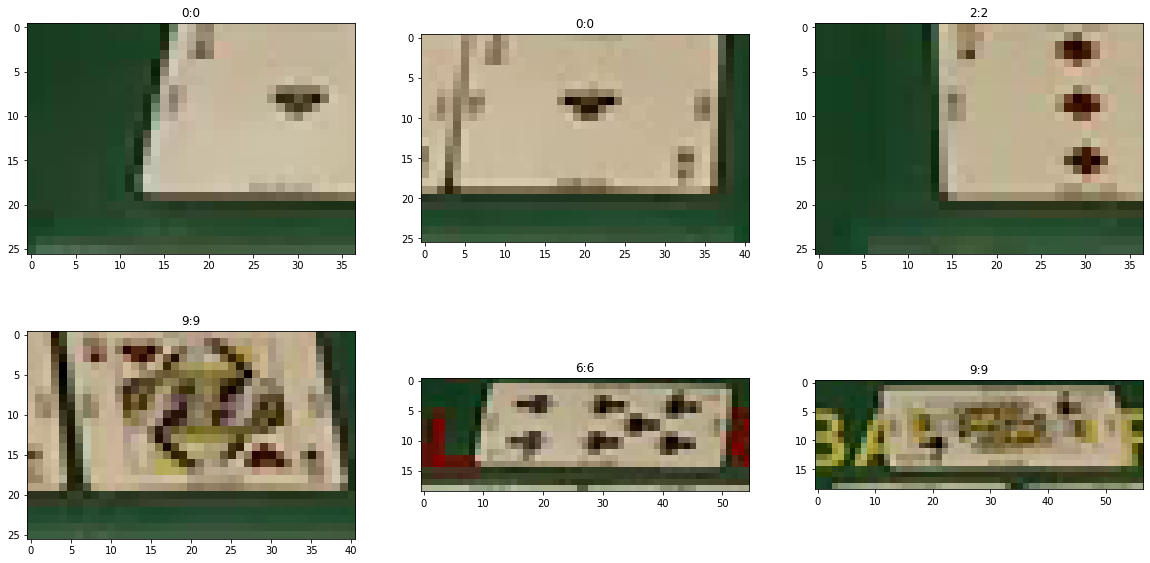

In [7]:
plt.figure(figsize=(20,10))
for j in range(6):
    plt.subplot(2,3,j+1); plt.imshow(cardsCollection[j])
    tmpstr = str(labelsCollection[j])+':'+str(preds[j])
    plt.title(tmpstr)